Importations

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import inspect
from scipy.interpolate import interp1d

Parameters of Option

In [2]:
def get_option_type():
    while True:
        option_type = input('Enter the type of the Option (Call or Put): ')
        if option_type.lower() in ['call', 'put']:
            return option_type.capitalize()
        else:
            print("Invalid input. Please enter 'Call' or 'Put'.")

def get_underlying_asset_price():
    while True:
        S = input('Enter the Underlying Asset Price : ')
        try:
            underlying_asset_price = int(S)
            return underlying_asset_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_strike_price():
    while True:
        K = input('Enter the Strike Price : ')
        try:
            strike_price = int(K)
            return strike_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_maturity():
    while True:
        M = input('Enter the Maturity (in years): ')
        try:
            maturity = float(M)
            if maturity > 0:
                return maturity
            else:
                print("Invalid value. Please enter a positive number.")
        except ValueError:
            print("Invalid number type. Please enter a valid number.")
            
def get_volatility():
    while True:
        vol = input('Enter the Volatility (between 0 and 1): ')
        try:
            volatility = float(vol)
            if 0 <= volatility <= 1:
                return volatility
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_rf():
    while True:
        rf = input('Enter the Risk-Free Interest rate (between 0 and 1): ')
        try:
            risk_free = float(rf)
            if 0 <= risk_free <= 1:
                return risk_free
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_dividend():
    while True:
        d = input('Enter the Dividend Rate (between 0 and 1): ')
        try:
            div_rate = float(d)
            if 0 <= div_rate <= 1:
                return div_rate
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")


In [3]:
Option_type = get_option_type()
print(f"Option Type: {Option_type}")

S=get_underlying_asset_price()
print(f"Underlying Asset Price: {S} $")

K = get_strike_price()
print(f"Strike Price: {K} $")

T=get_maturity()
print(f"Volatility: {T} years")

volatility = get_volatility()
print(f"Volatility: {volatility*100} %")

r = get_rf()
print(f"Risk-Free: {r*100} %")

q = get_dividend()
print(f"Dividend: {q*100} %")

Option Type: Call
Underlying Asset Price: 100 $
Strike Price: 110 $
Volatility: 1.0 years
Volatility: 20.0 %
Risk-Free: 5.0 %
Dividend: 2.0 %


Binomial Tree & Greeks Calculations

In [4]:
def get_treedepth():
    while True:
        steps = input('Enter the Depth of the Tree (between 0 and 100): ')
        try:
            steps = int(steps)
            if 0 <= steps <= 100:
                return steps
            else:
                print("Invalid value. Please enter a number between 0 and 100.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 100.")

In [5]:
N=get_treedepth()
print(f"Depth: {N}")

Depth: 10


In [139]:
def calculate_option_values(S, K, r, q, volatility, T, Option_type, N):

    """
    Calculate the option values using the binomial tree model.

    Parameters:
    - S: float
        Initial price of the underlying asset.
    - K: float
        Strike price of the option.
    - r: float
        Risk-free interest rate (annualized, continuously compounded).
    - q: float
        Dividend yield of the underlying asset (continuous).
    - volatility: float
        Volatility of the underlying asset.
    - T: float
        Time to maturity of the option (in years).
    - Option_type: str
        Type of the option ('call' or 'put').
    - N: int
        Number of steps in the binomial tree.

    Returns:
    - option_values: list of lists
        A 2D list containing the option values at each node of the binomial tree.
    """
    delta_T = T / N
    up = math.exp(volatility * math.sqrt(delta_T))
    down = math.exp(-volatility * math.sqrt(delta_T))
    p = (math.exp((r - q) * delta_T) - down) / (up - down)
    discount_factor = math.exp(-r * delta_T)

    asset_prices = [[0 for _ in range(j + 1)] for j in range(N + 1)]
    option_values = [[0 for _ in range(j + 1)] for j in range(N + 1)]

    for j in range(N + 1):
        asset_prices[N][j] = S * (up ** j) * (down ** (N - j))
        if Option_type.lower() == 'call':
            option_values[N][j] = max(asset_prices[N][j] - K, 0)
        else:
            option_values[N][j] = max(K - asset_prices[N][j], 0)

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            asset_prices[i][j] = S * (up ** j) * (down ** (i - j))
            hold_value = discount_factor * (p * option_values[i + 1][j + 1] + (1 - p) * option_values[i + 1][j])
            if Option_type.lower() == 'call':
                exercise_value = max(asset_prices[i][j] - K, 0)
            else:
                exercise_value = max(K - asset_prices[i][j], 0)

            option_values[i][j] = max(hold_value, exercise_value)

    return option_values

def binomial_tree_method(S, K, T, r, volatility, q, N, Option_type):
    """
    Calculates the price of an American option and its Greeks (Delta, Gamma, Theta, Vega, Rho)
    using the binomial tree model.

    Parameters:
    - S: Initial price of the underlying asset
    - K: Strike price of the option
    - T: Time to maturity of the option
    - r: Risk-free interest rate (annualized, continuously compounded)
    - volatility: Volatility of the underlying asset
    - q: Dividend yield of the underlying asset (continuous)
    - N: Number of steps in the binomial tree
    - Option_type: Type of the option ('call' or 'put')

    Returns:
    - option_price: Price of the American option
    - asset_prices: 2D list of asset prices at each node of the binomial tree
    - option_values: 2D list of option values at each node
    - greeks_data: Dictionary containing Delta, Gamma, Theta, Vega, Rho
    """
    delta_T = T / N
    up = math.exp(volatility * math.sqrt(delta_T))
    down = math.exp(-volatility * math.sqrt(delta_T))

    asset_prices = [[0 for _ in range(j + 1)] for j in range(N + 1)]

    for j in range(N + 1):
        asset_prices[N][j] = S * (up ** j) * (down ** (N - j))

    delta = [[0 for _ in range(j + 1)] for j in range(N)]
    gamma = [[0 for _ in range(j + 1)] for j in range(N)]
    theta = [[0 for _ in range(j + 1)] for j in range(N)]

    option_values=calculate_option_values(S, K, r, q, volatility, T, Option_type, N)

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            asset_prices[i][j] = S * (up ** j) * (down ** (i - j))

            delta[i][j] = (option_values[i + 1][j + 1] - option_values[i + 1][j]) / (asset_prices[i + 1][j + 1] - asset_prices[i + 1][j])

            d_up = (option_values[i + 1][j + 1] - option_values[i][j]) / (asset_prices[i + 1][j + 1] - asset_prices[i][j])
            d_down = (option_values[i][j] - option_values[i + 1][j]) / (asset_prices[i][j] - asset_prices[i + 1][j])
            gamma[i][j] = -(d_up - d_down) / ((asset_prices[i + 1][j + 1] - asset_prices[i + 1][j]) * asset_prices[i][j])*1000

            theta[i][j] = (option_values[i + 1][j] - option_values[i][j]) / delta_T

    epsilon = 0.001  # Small change in volatility
    vega = [[0 for _ in range(j + 1)] for j in range(N)]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            volatility_up = volatility + epsilon
            volatility_down = volatility - epsilon

            option_values_vol_up = calculate_option_values(S, K, r, q, volatility_up, T, Option_type, N)
            option_values_vol_down = calculate_option_values(S, K, r, q, volatility_down, T, Option_type, N)

            vega[i][j] = (option_values_vol_up[i][j] - option_values_vol_down[i][j]) / (2 * epsilon)

    epsilon_r = 0.01  # Small change in interest rate
    rho = [[0 for _ in range(j + 1)] for j in range(N)]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            interest_rate_up = r + epsilon_r
            interest_rate_down = r - epsilon_r

            option_values_r_up = calculate_option_values(S, K, interest_rate_up, q, volatility, T, Option_type, N)
            option_values_r_down = calculate_option_values(S, K, interest_rate_down, q, volatility, T, Option_type, N)

            rho[i][j] = (option_values_r_up[i][j] - option_values_r_down[i][j]) / (2 * epsilon_r)

    greeks_data = {
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho
    }
    return option_values[0][0], asset_prices, option_values, greeks_data



In [71]:
def plot_binomial_tree(asset_prices, option_values, option_type):

    """
    Plots the binomial tree for asset prices and option values.

    Parameters:
    - asset_prices: 2D list of asset prices at each node of the binomial tree
    - option_values: 2D list of option values at each node of the binomial tree
    - option_type: Type of the option ('call' or 'put')
    """
        
    N = len(asset_prices) - 1
    G = nx.DiGraph()
    pos = {}
    labels = {}

    for i in range(N + 1):
        for j in range(i + 1):
            G.add_node((i, j))
            pos[(i, j)] = (j - i / 2, i)
            labels[(i, j)] = f'{asset_prices[i][j]:.2f}\n{option_values[i][j]:.2f}'

            if i < N:
                G.add_edge((i, j), (i + 1, j), arrowstyle='->', arrowsize=10)
                G.add_edge((i, j), (i + 1, j + 1), arrowstyle='->', arrowsize=10)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1500, node_color='lightblue', font_size=8, font_weight='bold', arrows=True)
    plt.title(f'Binomial Tree for {option_type.capitalize()} Option Pricing')
    plt.gca().invert_yaxis()
    plt.show()

Option Value : 5.26 $
Value of Delta for the American Call Option is : 0.4
Value of Gamma for the American Call Option is : 0.02
Value of Theta for the American Call Option is : -5.05
Value of Vega for the American Call Option is : 41.67
Value of Rho for the American Call Option is : 34.37


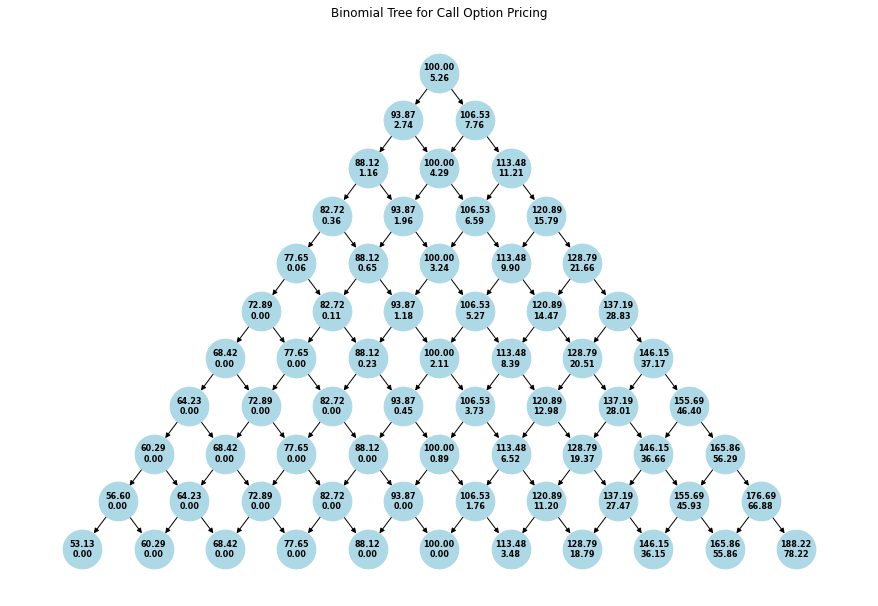

In [141]:
Option_type="Call"
option_value, asset_prices, option_values,greeks_data=binomial_tree_method(S, K, T, r, volatility, q, N, Option_type)
print("Option Value :",f'\033[1m{np.round(option_value,2)} $\033[0m')
for key in greeks_data.keys() : 
    print(f'Value of\033[1m {key.capitalize()}\033[0m for the American {Option_type} Option is : \033[1m{np.round(greeks_data[key][0][0],2)}\033[0m')
plot_binomial_tree(asset_prices, option_values,Option_type)

In [118]:
from scipy.interpolate import make_interp_spline

def plot_greek_asset_prices(asset_prices, greek, greek_name, option_type, K):
    plt.figure(figsize=(18, 8))
    
    # Interpolating to make the curve smooth
    final_step = len(greek) - 1
    asset_prices_final = np.array(asset_prices[final_step])
    greek_final = np.array(greek[final_step])
    
    # Creating a B-spline representation of the data
    X_Y_Spline = make_interp_spline(asset_prices_final, greek_final)
    
    # Generating a finer set of asset prices for smooth curve
    asset_prices_fine = np.linspace(asset_prices_final.min(), asset_prices_final.max(), 500)
    greek_fine = X_Y_Spline(asset_prices_fine)
    
    # Plotting the smooth curve
    plt.plot(asset_prices_fine, greek_fine, label=greek_name)
    plt.scatter(asset_prices_final, greek_final, color='red')  # Marking original points for reference
    plt.xlabel('Asset Price')
    plt.ylabel(greek_name)
    plt.title(f'{greek_name} for American {option_type} option with Strike = {K} $')
    plt.legend()
    plt.grid(True)
    plt.show()


In [126]:
def plot_greek_convergence(N, step, greek_name, option_type):
    steps = [i for i in range(step, N, step)]
    greek_values = []
    
    for el in steps:
        option_value, asset_prices, option_values, greeks_data = binomial_tree_method(S, K, T, r, volatility, q, el, Option_type)
        greek_values.append(greeks_data[greek_name.lower()][0][0])
    
    plt.figure(figsize=(18, 8))
    
    # Interpolating to make the curve smooth
    steps_interp = np.linspace(min(steps), max(steps), 500)
    greek_interp = make_interp_spline(steps, greek_values)(steps_interp)
    
    plt.plot(steps_interp, greek_interp, linestyle='-', color='red', label=greek_name)
    plt.xlabel('Number of Steps')
    plt.ylabel(f'{greek_name}')
    plt.title(f'{greek_name} Convergence for American {option_type} option with Strike = {K} $')
    plt.grid(True)
    plt.legend()
    plt.show()

In [108]:
def get_plot_greek(option_type):
    greek_table=['delta','gamma','theta','vega','rho']
    while True:
        greek = input('Enter the Greek to plot, choose between Delta, Gamma, Theta, Vega and Rho : ')
        try:
            greek_name = greek.lower()
            if greek_name in greek_table:
                method=input('Enter the method you want to see between Greek convergence and greek vs asset price (1 or 2): ')
                if int(method) not in [1,2] : 
                    print("Tape 1 or 2.")
                elif int(method) == 1 : 
                    Depth_max=input('Enter the maximal depth of the tree : ')
                    steps=input('Enter the steps for the convergence : ')
                    return plot_greek_convergence(int(Depth_max),int(steps),greek_name.capitalize(),option_type)
                else : return plot_greek_asset_prices(asset_prices, greeks_data[greek_name], greek_name.capitalize(),option_type,K)
            else:
                print("Invalid Greek. Please enter a valid Greek: Delta, Gamma, Theta, Vega, or Rho.")
                
        except ValueError:
            print("Invalid type. Please enter a Greek in string format between Delta, Gamma, Theta, Vega and Rho.")

Greek Plots

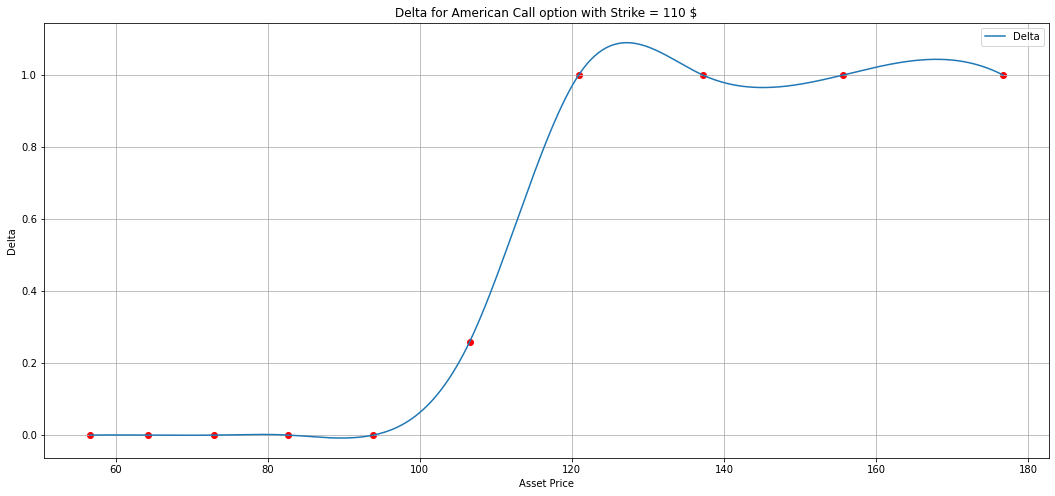

In [134]:
get_plot_greek(Option_type)

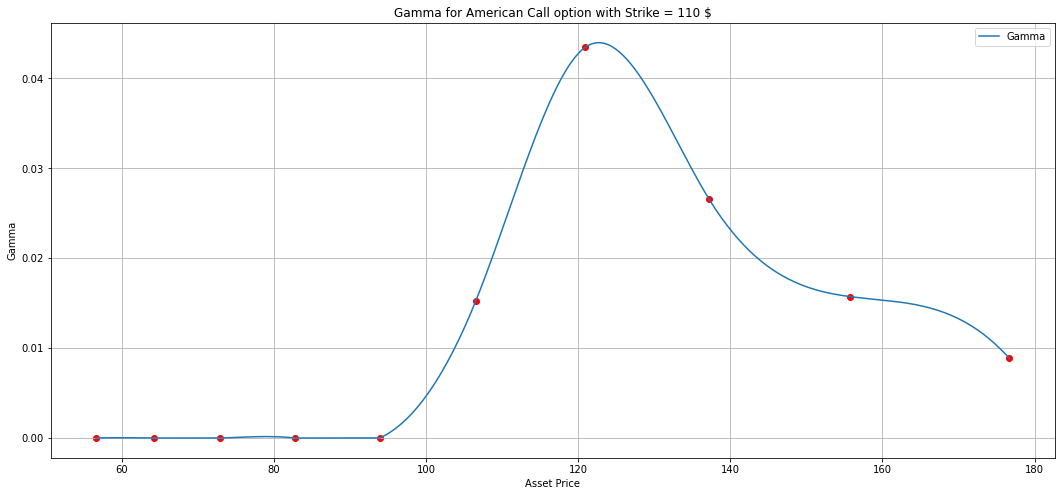

In [116]:
get_plot_greek(Option_type)

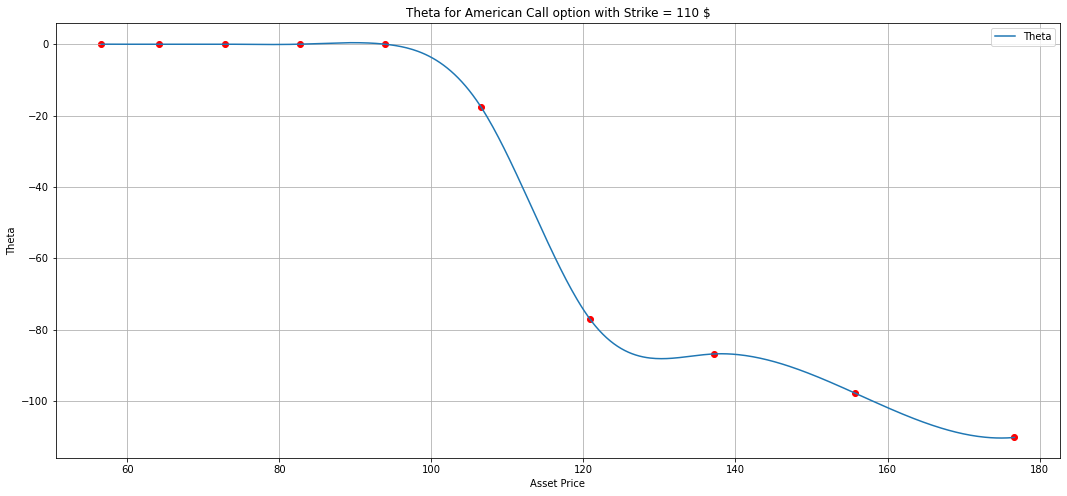

In [120]:
get_plot_greek(Option_type)

Greeks Convergence with N

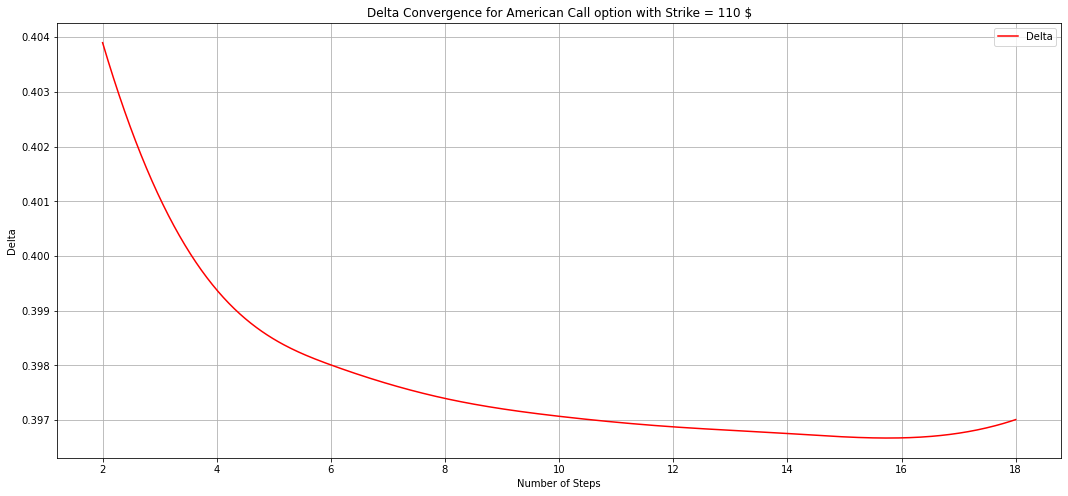

In [127]:
get_plot_greek(Option_type)

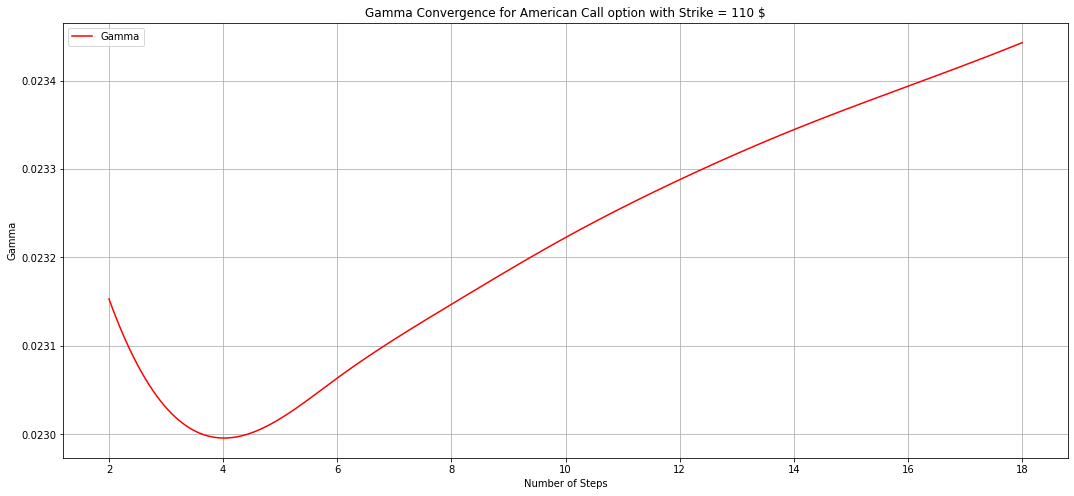

In [128]:
get_plot_greek(Option_type)

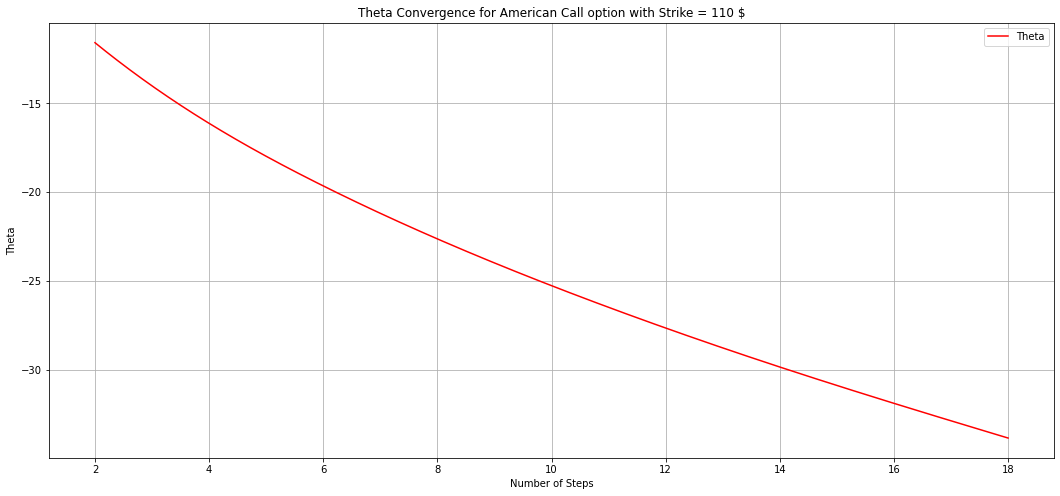

In [129]:
get_plot_greek(Option_type)

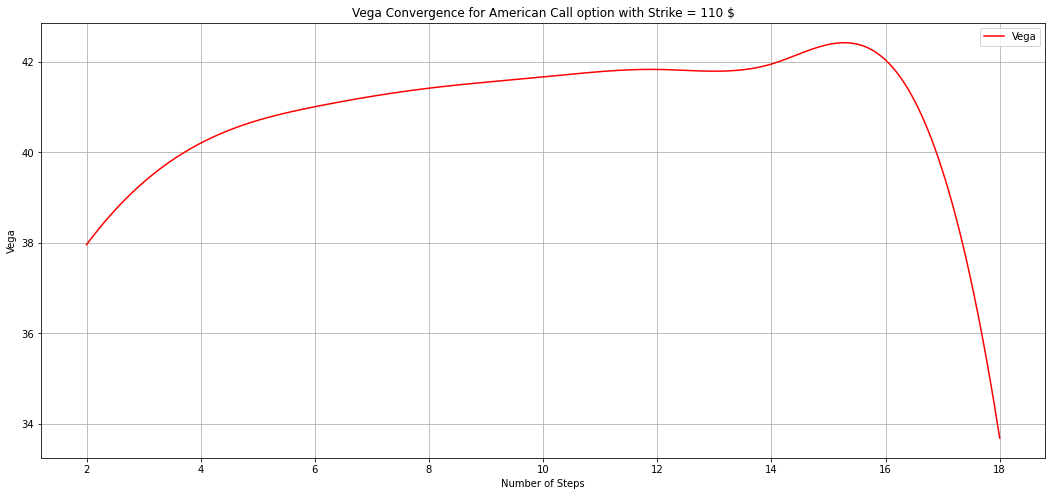

In [130]:
get_plot_greek(Option_type)

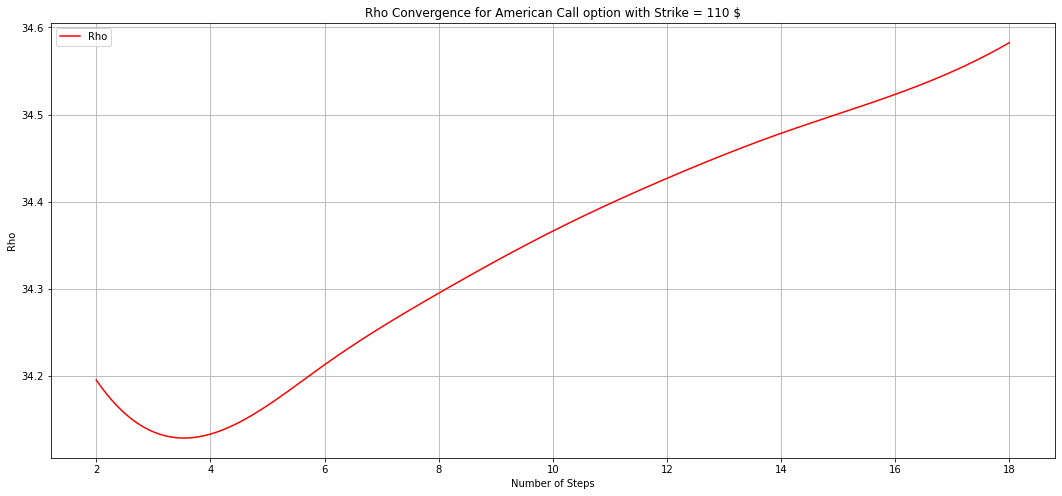

In [131]:
get_plot_greek(Option_type)

Monte Carlo Simualtion

In [201]:
def american_option_price_and_plot(S0, K, r, sigma, option_type, T, N, paths):
    
    """
    Price American option using Monte Carlo simulation and plot simulated paths of the underlying asset.

    Parameters:
    -----------
    S0 : float
        Initial stock price.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate (annualized).
    sigma : float
        Volatility of the stock price (annualized).
    option_type : str
        Type of the option, either 'call' or 'put'.
    T : float
        Time to maturity of the option (in years).
    N : int
        Number of time steps in the simulation.
    paths : int
        Number of simulated paths for the underlying asset.

    Returns:
    --------
    tuple
        A tuple containing:
        - Estimated price of the American option.
        - Delta (sensitivity of option price to change in underlying asset price).
        - Gamma (sensitivity of Delta to changes in underlying asset price).
        - Theta (sensitivity of option price to change in time).
        - Vega (sensitivity of option price to change in volatility).
        - Rho (sensitivity of option price to change in risk-free interest rate).
    """

    dt = T / N
    t = np.linspace(0., T, N+1)
    discount_factor = np.exp(-r * dt)
    
    S = np.zeros((paths, N+1))
    S[:, 0] = S0
    
    for i in range(1, N+1):
        Z = np.random.normal(size=paths)
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    if option_type == 'call':
        V = np.maximum(0, S - K)  
    else:
        V = np.maximum(0, K - S)

    for i in range(N-1, 0, -1):
        immediate_exercise_value = np.maximum(0, S[:, i] - K)
        discount_future_value = discount_factor * V[:, i+1]
        continuation_value = np.maximum(immediate_exercise_value, discount_future_value)
        V[:, i] = continuation_value

    option_prices = discount_factor * V[:, 1]
    
    epsilon = 0.001  # Small perturbation for Delta and Vega calculation
    
    # Delta
    S_plus = S0 * np.exp(sigma * np.sqrt(dt) * np.random.normal(size=paths))
    S_minus = S0 * np.exp(-sigma * np.sqrt(dt) * np.random.normal(size=paths))
    
    if option_type == 'call':
        payoff_plus = np.maximum(0, S_plus - K)
        delta = np.mean(payoff_plus) / (S0 * epsilon)
        gamma = np.mean(payoff_plus / (S_plus * S_plus)) / (S0 * epsilon)
    else:
        payoff_minus = np.maximum(0, K - S_minus)
        delta = np.mean(payoff_minus) / (S0 * epsilon)
        gamma = np.mean(payoff_minus / (S_minus * S_minus)) / (S0 * epsilon)
    
    # Theta
    theta = (np.mean(discount_factor * V[:, 1]) - np.mean(V[:, 1])) / dt
    
    # Vega
    S_vega = S0 * np.exp(sigma * np.sqrt(dt + epsilon) * np.random.normal(size=paths))
    if option_type == 'call':
        payoff_vega = np.maximum(0, S_vega - K)
    else:
        payoff_vega = np.maximum(0, K - S_vega)
    vega = np.mean(payoff_vega) / epsilon
    
    # Rho
    rho = T * np.mean(discount_factor * V[:, 1])
    
    # Plotting
    plt.figure(figsize=(15, 8))
    for i in range(paths):
        plt.plot(t, S[i, :], lw=1.5, alpha=0.7, label=f'Path {i+1}')

    plt.title('Simulated Paths of Underlying Asset Price (Geometric Brownian Motion)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Estimated American {option_type} option price: {np.mean(option_prices):.4f}")
    print(f"Delta: {delta:.4f}")
    print(f"Gamma: {gamma:.4f}")
    print(f"Theta: {theta:.4f}")
    print(f"Vega: {vega:.4f}")
    print(f"Rho: {rho:.4f}")

    return np.mean(option_prices), delta, gamma, theta, vega, rho


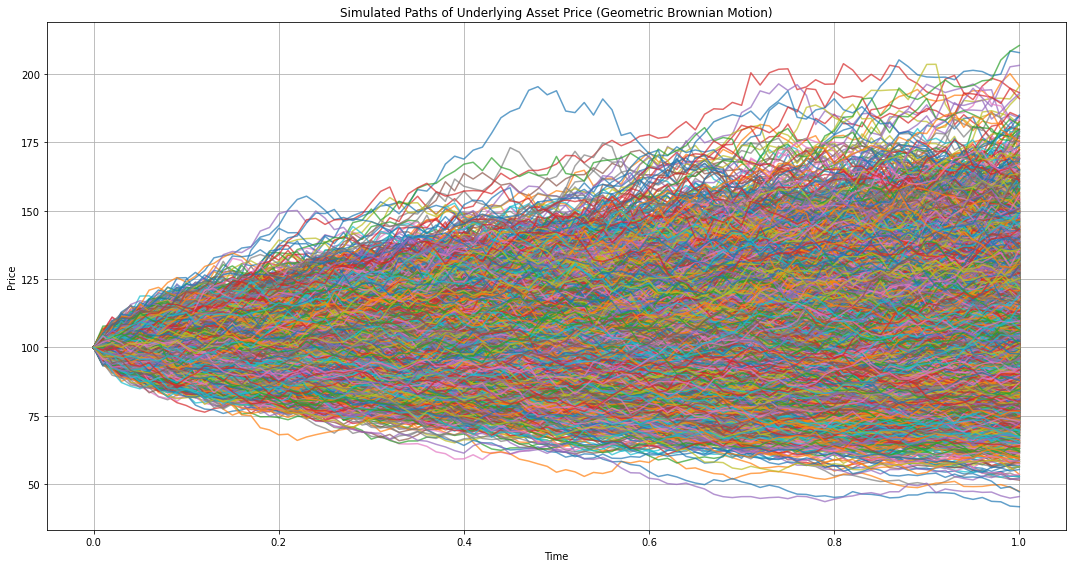

Estimated American Call option price: 21.7078
Delta: 7.6041
Gamma: 0.0008
Theta: -1.0857
Vega: 811.5114
Rho: 21.7078


In [202]:
option_price,delta, gamma, theta, vega, rho = american_option_price_and_plot(S, K, r, volatility,Option_type,T, 100, 10000)
